In [9]:
import pandas as pd
import numpy as np
import os
import joblib
import time
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

pd.set_option('display.max_columns', None)
load_dotenv(override=True)

DB_URL = f"postgresql+psycopg2://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
engine = create_engine(DB_URL)

In [10]:
TABLE_NAME = "superstore_data_cleaned"
TARGET_COLUMN = "Response"

df = pd.read_sql(f"SELECT * FROM {TABLE_NAME}", engine)

#Remove columns that are not needed for training (Id)
cols_to_drop = ['Id']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

# Encode columns
object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if TARGET_COLUMN in object_cols:
    object_cols.remove(TARGET_COLUMN)
if object_cols:
    df = pd.get_dummies(df, columns=object_cols, drop_first=True)

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

print(f"X shape: {X.shape}")

X shape: (2227, 31)


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(C=0.5, max_iter=2000, random_state=42),
    
    "Random Forest": RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_leaf=5, 
        random_state=42, 
        n_jobs=-1
    ),
    
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        n_iter_no_change=10, 
        validation_fraction=0.1, 
        random_state=42
    ),
    
    "SVC": SVC(C=0.8, probability=True, random_state=42)
}

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results = []
timestamp = pd.Timestamp.now()

for name, model in models.items():
    print(f"Training: {name}")
    
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    mean_scores = {
        'model_name': name,
        'accuracy': np.mean(scores['test_accuracy']),
        'precision': np.mean(scores['test_precision']),
        'recall': np.mean(scores['test_recall']),
        'f1': np.mean(scores['test_f1']),
        'roc_auc': np.mean(scores['test_roc_auc']),
        'training_time': np.mean(scores['fit_time']),
        'created_at': timestamp,
        'source': 'train'
    }
    results.append(mean_scores)
    
    # Training logging
    try:
        pd.DataFrame([{
            'model_name': name,
            'source': 'train',
            'algorithm': model.__class__.__name__,
            'created_at': timestamp
        }]).to_sql('models', engine, if_exists='append', index=False)
    except Exception as e:
        print(f"Error writing to models: {e}")

# Saving metrics
metrics_df = pd.DataFrame(results)
metrics_df.to_sql('model_metrics', engine, if_exists='append', index=False)

print("\n Result")
display(metrics_df.sort_values(by='f1', ascending=False))


 Training 

Training: Logistic Regression
Training: Random Forest
Training: Gradient Boosting
Training: SVC

 Result


,model_name,accuracy,precision,recall,f1,roc_auc,training_time,created_at,source
1,Random Forest,0.862153,0.542555,0.493939,0.515340,0.861413,0.596582,2026-01-10 11:54:09.369438,train
2,Gradient Boosting,0.861258,0.537426,0.490909,0.510511,0.856565,2.885696,2026-01-10 11:54:09.369438,train
3,SVC,0.815444,0.419867,0.648485,0.508867,0.846067,1.289708,2026-01-10 11:54:09.369438,train
0,Logistic Regression,0.778170,0.375095,0.742424,0.498311,0.846429,0.021993,2026-01-10 11:54:09.369438,train



 Feature importance analysis 

Analyzing: Logistic Regression
Analyzing: Random Forest


C:\Users\user\AppData\Local\Temp\ipykernel_5312\3614235867.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, ax=axes[i], palette='viridis')
C:\Users\user\AppData\Local\Temp\ipykernel_5312\3614235867.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, ax=axes[i], palette='viridis')


Analyzing: Gradient Boosting


C:\Users\user\AppData\Local\Temp\ipykernel_5312\3614235867.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, ax=axes[i], palette='viridis')


Analyzing: SVC


C:\Users\user\AppData\Local\Temp\ipykernel_5312\3614235867.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, ax=axes[i], palette='viridis')


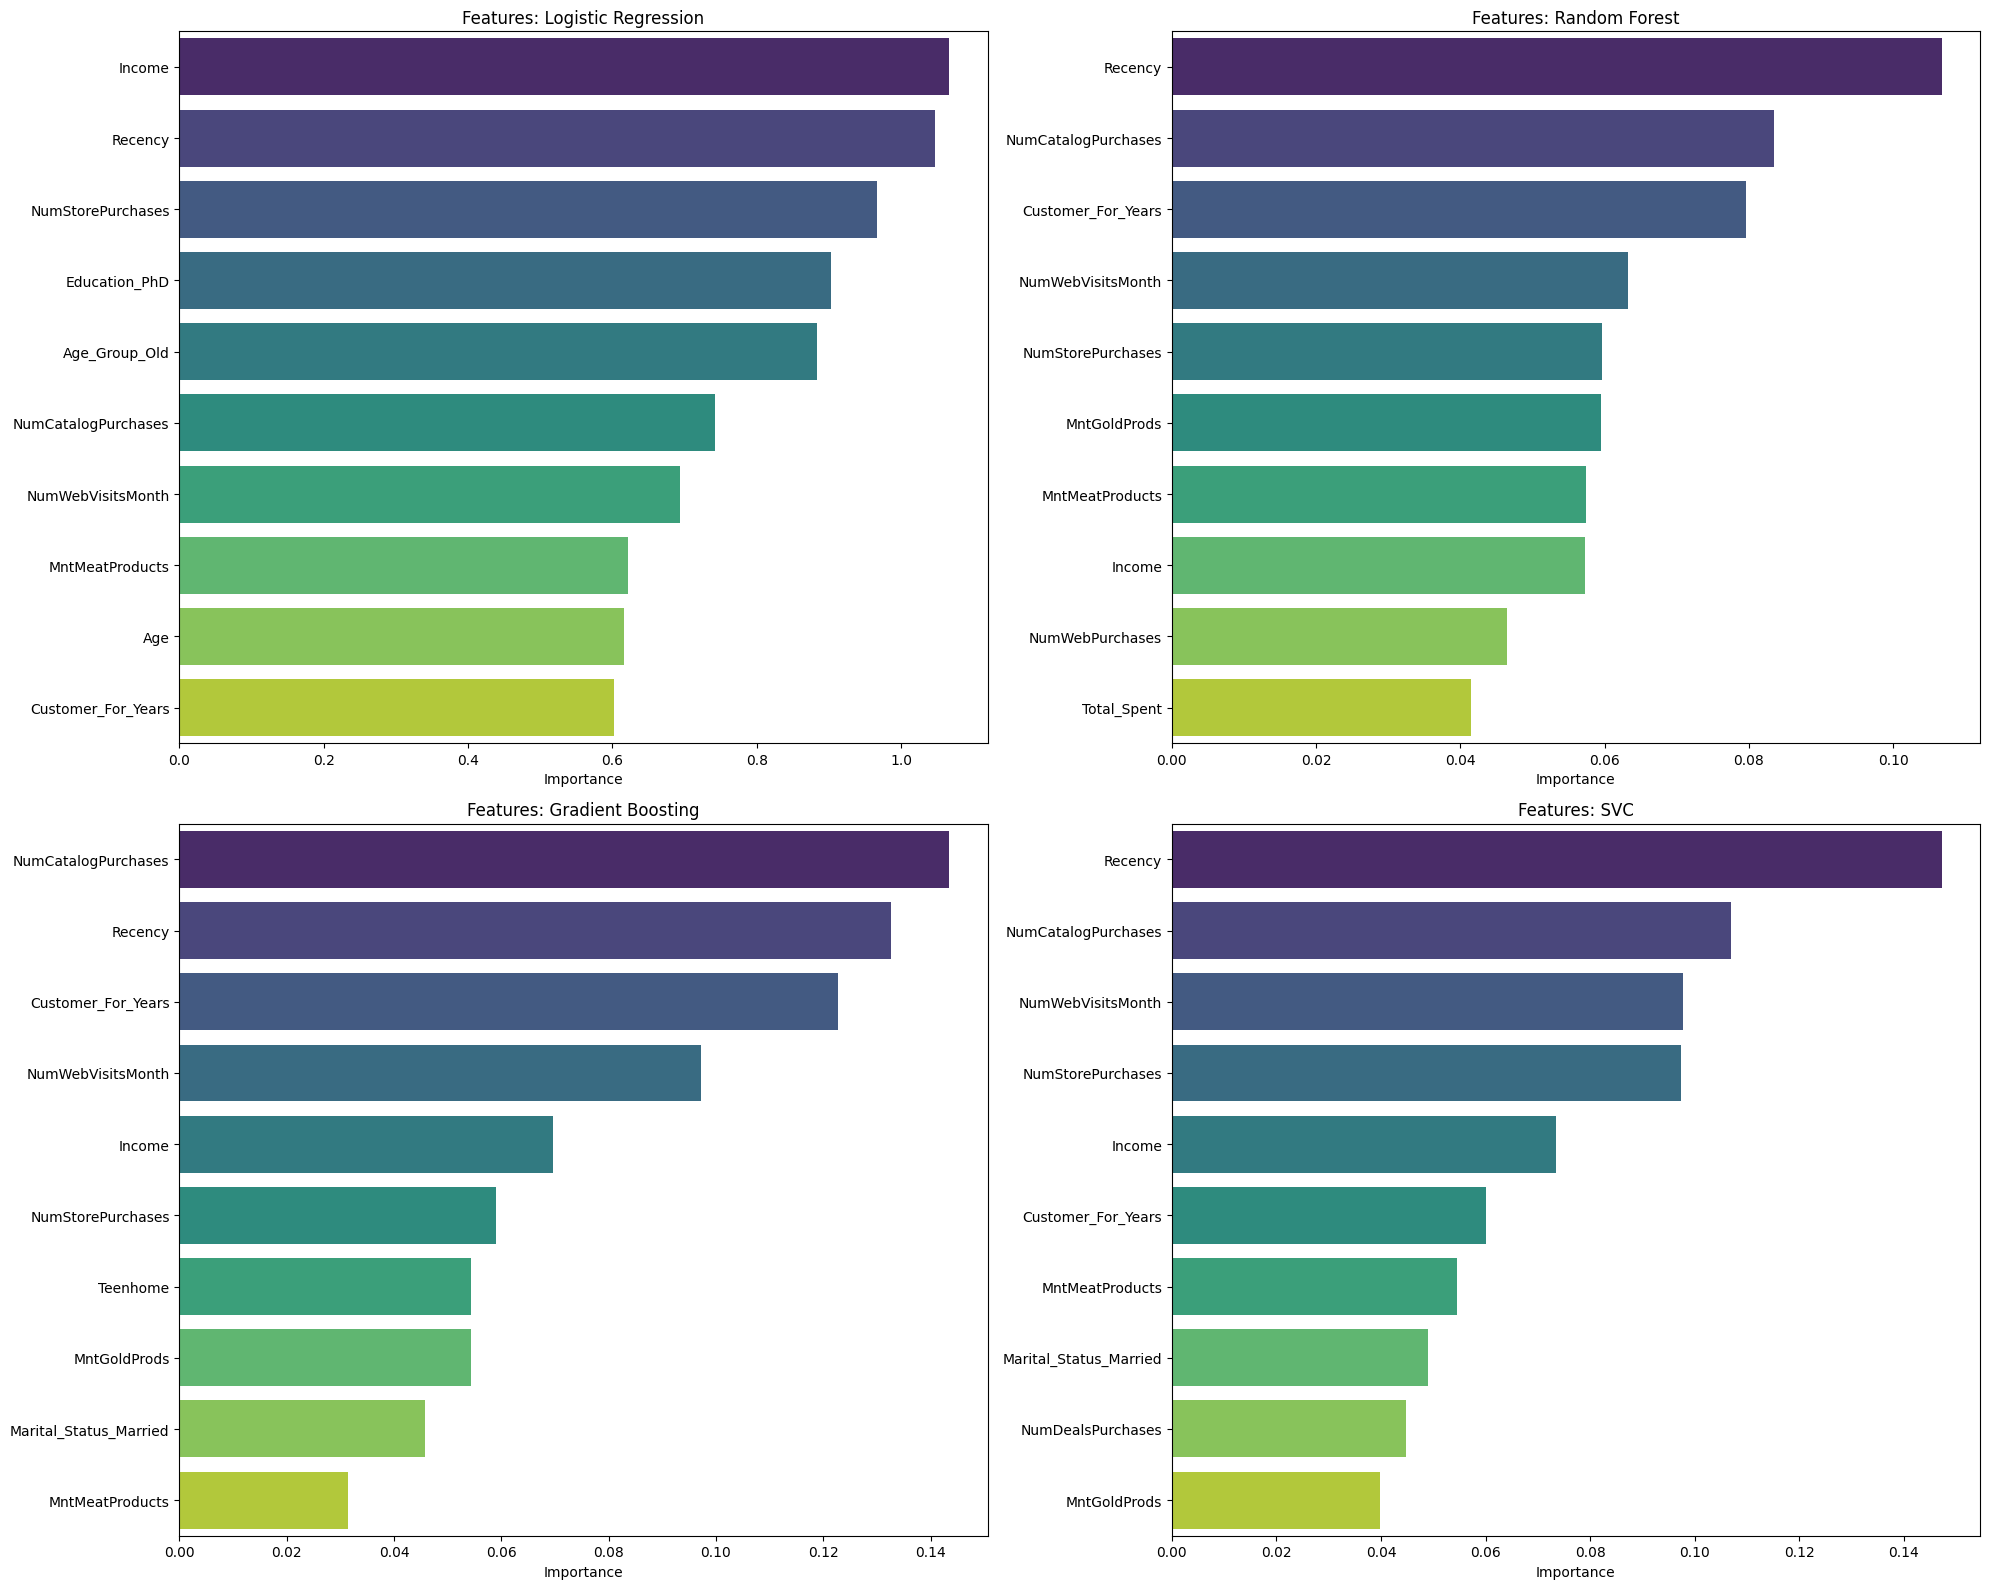

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

print("\n Feature importance analysis \n")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    print(f"Analyzing: {name}")
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    pipeline.fit(X, y)
    trained_model = pipeline.named_steps['classifier']
    feature_names = X.columns
    importances = None
        
    # Random Forest, Gradient Boosting
    if hasattr(trained_model, 'feature_importances_'):
        importances = trained_model.feature_importances_
        
    # Logistic Regression
    elif hasattr(trained_model, 'coef_'):
        importances = np.abs(trained_model.coef_[0])
        
    # SVC 
    else:
        perm_result = permutation_importance(
            pipeline, X, y, n_repeats=5, random_state=42, n_jobs=-1, scoring='f1'
        )
        importances = perm_result.importances_mean

    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Features: {name}')
    axes[i].set_xlabel('Importance')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [14]:
from sklearn.base import clone
best_initial_row = metrics_df.sort_values(by='f1', ascending=False).iloc[0]
best_model_name = best_initial_row['model_name']
print(f"Best baseline model: {best_model_name} (F1: {best_initial_row['f1']:.4f})")
base_estimator = clone(models[best_model_name])

all_param_grids = {
    "Logistic Regression": {
        'model__C': [0.01, 0.1, 1.0, 5.0], 
        'model__solver': ['liblinear', 'lbfgs']
    },
    
    "Random Forest": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [5, 10, 15],       
        'model__min_samples_leaf': [5, 10],    
        'model__min_samples_split': [15, 20]
    },
    
    "Gradient Boosting": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5],            
        'model__min_samples_leaf': [5, 10]
    },
    
    "SVC": {
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf'] 
    }
}

current_param_grid = all_param_grids[best_model_name]

pipeline_tune = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', base_estimator)
])

grid = GridSearchCV(
    estimator=pipeline_tune, 
    param_grid=current_param_grid, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1
)

grid.fit(X, y)

print(f"\n Best parameters: {grid.best_params_}")
print(f"Best F1-score: {grid.best_score_:.4f}")

best_model = grid.best_estimator_

if not os.path.exists("models"):
    os.makedirs("models")

safe_model_name = best_model_name.replace(" ", "_")
filename = f"models/best_{safe_model_name}_{pd.Timestamp.now().strftime('%Y%m%d_%H%M')}.pkl"

joblib.dump(best_model, filename)

y_pred = best_model.predict(X)
try:
    y_prob = best_model.predict_proba(X)[:, 1]
    auc_score = roc_auc_score(y, y_prob)
except:
    y_prob = None
    auc_score = 0.0

final_metrics = {
    'model_name': f"{best_model_name} (Final)",
    'accuracy': accuracy_score(y, y_pred),
    'precision': precision_score(y, y_pred),
    'recall': recall_score(y, y_pred),
    'f1': f1_score(y, y_pred),
    'roc_auc': auc_score,
    'training_time': grid.refit_time_,
    'created_at': pd.Timestamp.now(),
    'source': f"optimized_file: {filename}"
}

pd.DataFrame([final_metrics]).to_sql('model_metrics', engine, if_exists='append', index=False)

display(pd.DataFrame([final_metrics]))

Best baseline model: Random Forest (F1: 0.5153)
Fitting 3 folds for each of 24 candidates, totalling 72 fits

 Best parameters: {'model__max_depth': 15, 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__n_estimators': 200}
Best F1-score: 0.2261


,model_name,accuracy,precision,recall,f1,roc_auc,training_time,created_at,source
0,Random Forest (Final),0.939829,0.78655,0.815152,0.800595,0.971687,0.380852,2026-01-10 11:55:51.371282,optimized_file: models/best_Random_Forest_2026...
